# Venomous snakes vs non-venomous snakes

This notebook has the goal of utilizing machine learning techniques to recognize whether a snake is venomous or not.

The recognition of venomous snakes can be especially important in situations where this distinction can help avoid accidents and minimize the risk of snake bites. However, it is highly recommended to maintain distance from all types of snakes.


## Steps

1. Use the DuckDuckGo API to download images of venomous snakes and non-venomous snakes from the search terms "venomous snake" and "non-venomous snake";
2. Fine-tune a pretrained neural network to recognize these two groups;
3. Try running this model with 2 pictures, one with venomous snake and one with non-venomous snake and see if it works.

In [1]:
# We will be using the fastai deep learning library to train and model our AI, and the DuckDuckGo API to search for images
!pip install -Uqq fastai duckduckgo_search

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 KB 4.0 MB/s eta 0:00:00


## Step 1: Download images


In [8]:
from duckduckgo_search import ddg_images
from fastcore.all import *

# Declaring the search terms that are going to be used to find images
searches = 'venomous snake', 'non-venomous snake'

# The function takes two parameters and passes them to ddg_images function: term, which is the search term to be used, and max_images
# The ddg_images function returns a list of dictionaries, where each dictionary corresponds to one image 
#     and contains information such as the image URL, image width and height, and the page URL where the image was found.
# The itemgot('image') method call extracts the image attribute (which contains the URL) from each item in the list.
# The search_images function returns a L object (a list) containing the URLs of the images found
def search_images(term, max_images=30):
    print(f"Searching for '{term}'")
    return L(ddg_images(term, max_results=max_images)).itemgot('image')

### Saving the images that are going to be used for testing

Saving the photo of a venomous snake:



Searching for 'venomous snake photos'


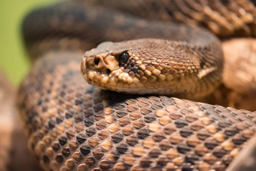

In [12]:
from fastdownload import download_url
from fastai.vision.all import *

download_url(search_images(searches[0] + ' photos', max_images=1)[0], 'venomous.jpg', show_progress=False)
Image.open('venomous.jpg').to_thumb(256,256)

Now let's do the same with non-venomous snake:

Searching for 'non-venomous snake photos'


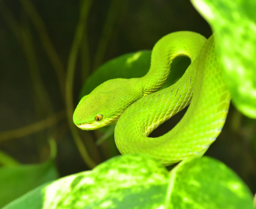

In [13]:
download_url(search_images(searches[1] + ' photos', max_images=1)[0], 'non-venomous.jpg', show_progress=False)
Image.open('non-venomous.jpg').to_thumb(256,256)

### Saving the images that are going to be used to train our model

Create a folder named "snakes" that will be used to store photos of venomous and non-venomous snakes that will be used in step 2.

In [20]:
path = Path('snakes')
from time import sleep

for snakes in searches:
    dest = (path/snakes)
    dest.mkdir(exist_ok=True, parents=True)
    download_images(dest, urls=search_images(f'{snakes} photo'))
    sleep(10)  # Pause between searches to avoid over-loading server
    download_images(dest, urls=search_images(f'{snakes} sun photo'))
    sleep(10)
    download_images(dest, urls=search_images(f'{snakes} shade photo'))
    sleep(10)
    resize_images(path/snakes, max_size=400, dest=path/snakes)

Searching for 'venomous snake photo'
Searching for 'venomous snake sun photo'
Searching for 'venomous snake shade photo'
Searching for 'non-venomous snake photo'
Searching for 'non-venomous snake sun photo'
Searching for 'non-venomous snake shade photo'


Some photos might not download correctly which could cause our model training to fail, so we'll remove them:

In [21]:
failed = verify_images(get_image_files(path))
failed.map(Path.unlink)
len(failed)

3

## Step 2: Train our model

To train the model, we need to use DataLoaders (Fastai uses DataBlock to create the DataLoaders), which is an object consisting of two sets: training set and validation set.

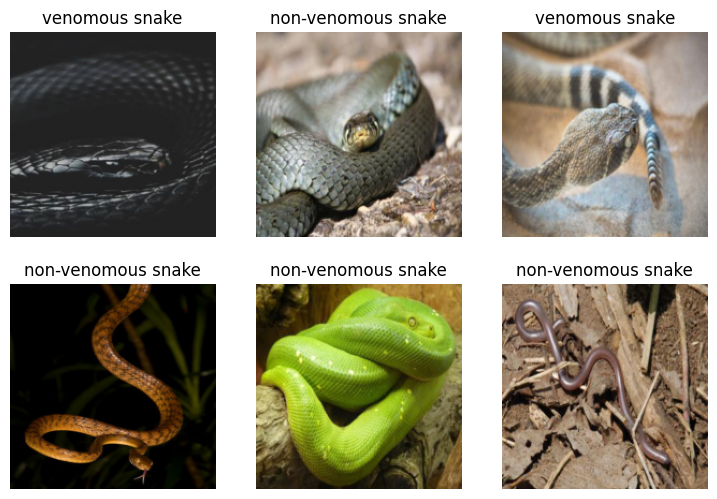

In [23]:
dls = DataBlock(
    blocks=(ImageBlock, CategoryBlock), 
    get_items=get_image_files, 
    # splitter: a function that splits the input data into training and validation sets
    # RandomSplitter is used to randomly split the data with a validation set percentage of 20%.
    splitter=RandomSplitter(valid_pct=0.2, seed=42),
    get_y=parent_label,
    item_tfms=[Resize(192, method='squish')]
).dataloaders(path, bs=32)

dls.show_batch(max_n=6)

Now we're ready to train our model. 

In [27]:
# This code creates a vision_learner object using the:
#   dls DataLoaders, 
#   the resnet18 pre-trained convolutional neural network architecture,
#   the error_rate metric for evaluation.
learn = vision_learner(dls, resnet18, metrics=error_rate)
# Then, the fine_tune method is used to fine-tune the pre-trained model on the dls DataLoaders for 3 cycles.
learn.fine_tune(3)

epoch,train_loss,valid_loss,error_rate,time
0,1.179470,0.889966,0.366667,00:31


epoch,train_loss,valid_loss,error_rate,time
0,0.479513,0.898682,0.300000,00:42
1,0.398521,0.854783,0.250000,00:43
2,0.302665,0.858162,0.250000,00:42


## Step 3: Test our model

First, let's test with the image of the venomous snake we saved earlier.

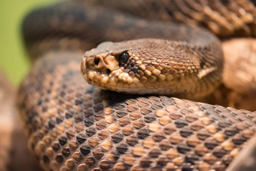

In [33]:
image = 'venomous.jpg'
Image.open(image).to_thumb(256,256)

In [34]:
is_venomous,_,probs = learn.predict(PILImage.create(image))
print(f"This is a: {is_venomous}.")
print(f"Probability it's a venomous snake: {1 - probs[0]:.4f}")

This is a: venomous snake.
Probability it's a venomous snake: 0.9917


Correct! Now, we will test with the non-venomous snake image that we saved earlier.

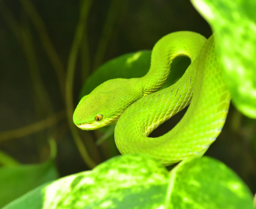

In [35]:
image = 'non-venomous.jpg'
Image.open(image).to_thumb(256,256)

In [36]:
is_venomous,_,probs = learn.predict(PILImage.create(image))
print(f"This is a: {is_venomous}.")
print(f"Probability it's a venomous snake: {1 - probs[0]:.4f}")

This is a: non-venomous snake.
Probability it's a venomous snake: 0.0012
